<a href="https://colab.research.google.com/github/tjdhir119/Covi-LAB/blob/main/CoviLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/covilab/Data/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/covilab/Data/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5144 files belonging to 3 classes.
Using 4116 files for training.
Found 5144 files belonging to 3 classes.
Using 1028 files for validation.


In [5]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
class_names = train_ds.class_names
print(class_names)

['COVID19', 'NORMAL', 'PNEUMONIA']


In [7]:
train_ds.cardinality().numpy()

129

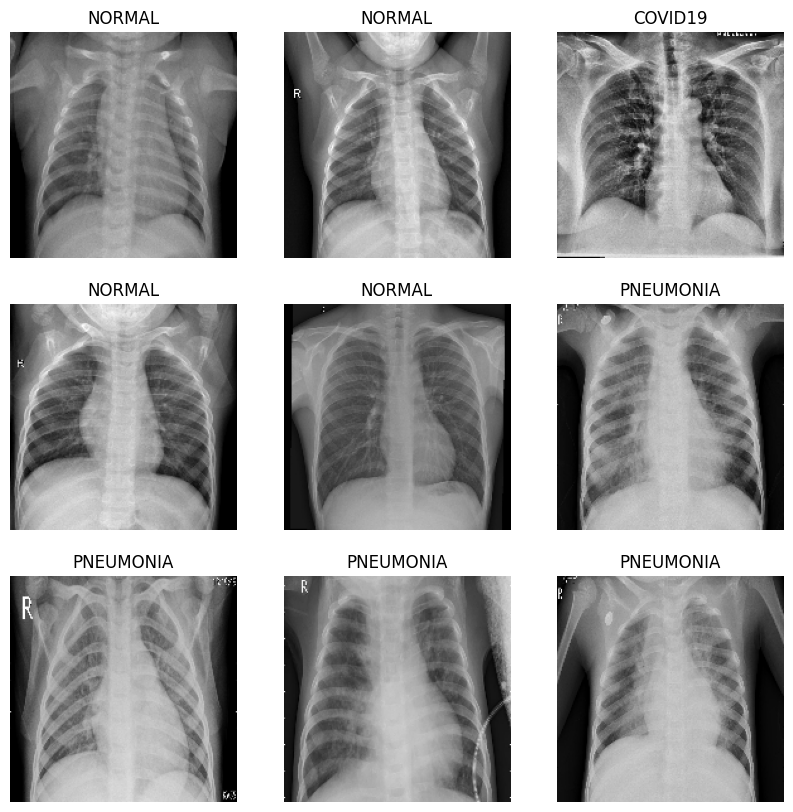

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.05),
     layers.experimental.preprocessing.RandomZoom(0.10)
    ]
)

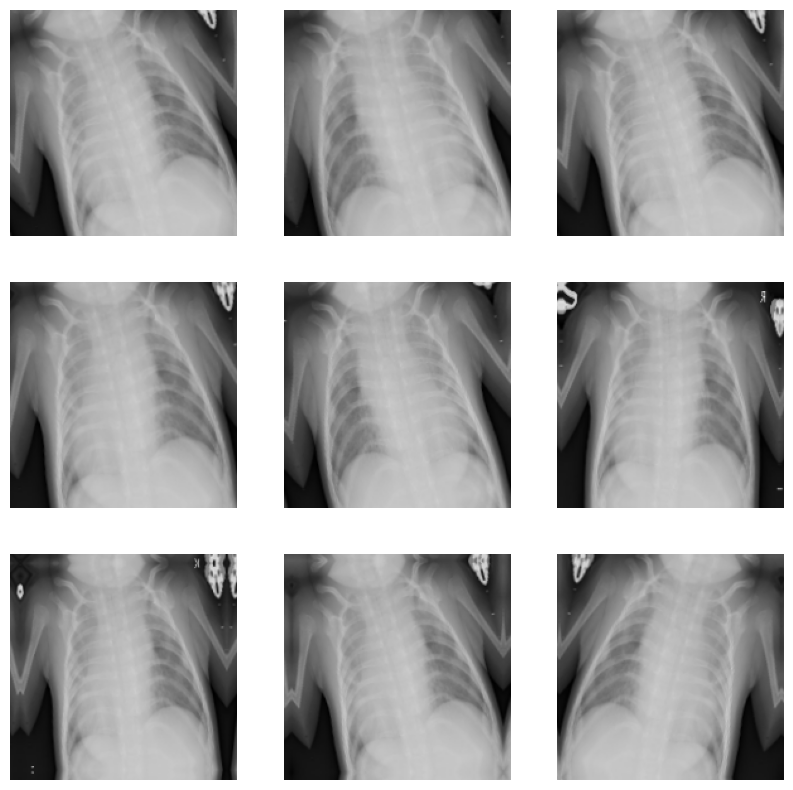

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [11]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

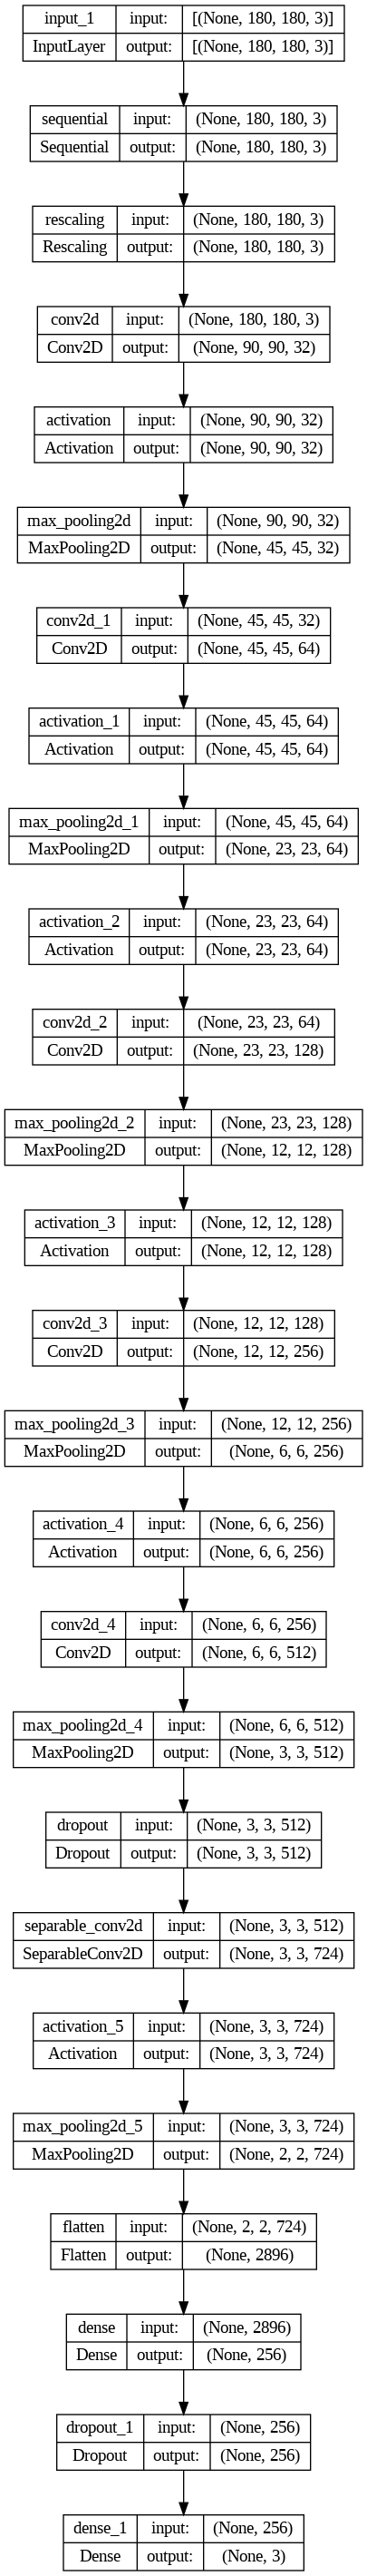

In [12]:
keras.backend.clear_session()

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 5, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Conv2D(64, 5, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    for size in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 5, padding="same")(x)
        x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Dropout(0.5)(x)
    x = layers.SeparableConv2D(724, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)

In [13]:
# checkpoint_filepath = '/content/content'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

# early_stop = tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     min_delta=0,
#     patience=6,
#     verbose=0,
#     restore_best_weights = True)

def scheduler(epoch, lr):
  if epoch < 9:
    return lr
  else:
    return lr * tf.math.exp(-0.008)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [14]:
epochs = 10

model.compile(optimizer= keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ["accuracy"])

history = model.fit(
    train_ds, epochs = epochs,
    callbacks = [ lr_callback],
    validation_data = val_ds
    )

Epoch 1/10
129/129 [==============================] - 1359s 11s/step - loss: 0.8922 - accuracy: 0.6572 - val_loss: 0.8385 - val_accuracy: 0.6634 - lr: 0.0010
Epoch 2/10
129/129 [==============================] - 467s 4s/step - loss: 0.6812 - accuracy: 0.7143 - val_loss: 0.5272 - val_accuracy: 0.7811 - lr: 0.0010
Epoch 3/10
129/129 [==============================] - 467s 4s/step - loss: 0.5003 - accuracy: 0.7952 - val_loss: 0.4136 - val_accuracy: 0.8152 - lr: 0.0010
Epoch 4/10
129/129 [==============================] - 463s 4s/step - loss: 0.3553 - accuracy: 0.8737 - val_loss: 0.2618 - val_accuracy: 0.9183 - lr: 0.0010
Epoch 5/10
129/129 [==============================] - 462s 4s/step - loss: 0.2779 - accuracy: 0.8980 - val_loss: 0.2181 - val_accuracy: 0.9261 - lr: 0.0010
Epoch 6/10
129/129 [==============================] - 457s 4s/step - loss: 0.2667 - accuracy: 0.9077 - val_loss: 0.1824 - val_accuracy: 0.9416 - lr: 0.0010
Epoch 7/10
129/129 [==============================] - 462s 4s/

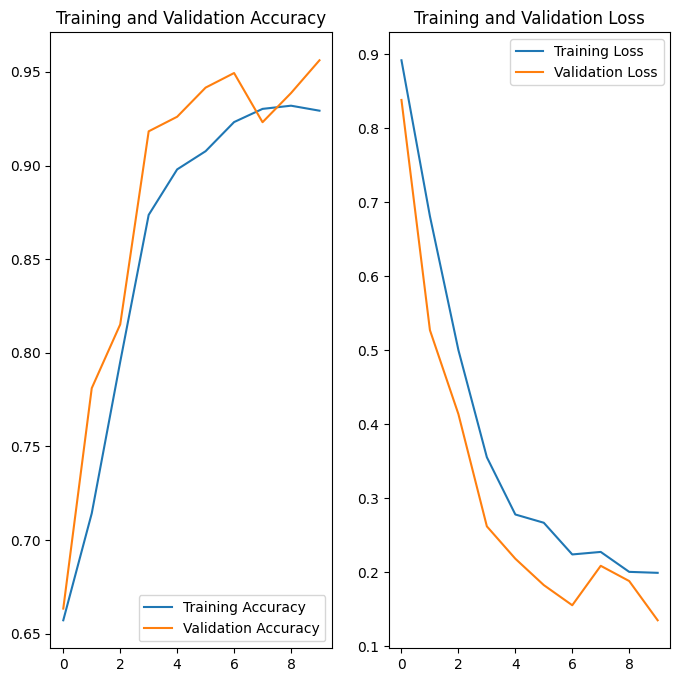

In [15]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
image_path = "/content/drive/MyDrive/covilab/Data/test/COVID19/COVID19(490).jpg"
image_path2 = "/content/drive/MyDrive/covilab/Data/test/NORMAL/NORMAL(1471).jpg"
image_path3 = "/content/drive/MyDrive/covilab/Data/test/PNEUMONIA/PNEUMONIA(4260).jpg"
merged_path = [image_path,image_path2,image_path3]

for img_path in merged_path:
    img = keras.preprocessing.image.load_img(
        img_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))

1/1 [==============================] - 0s 311ms/step
This image most likely belongs to COVID19 with a 47.78 percent confidence.
1/1 [==============================] - 0s 44ms/step
This image most likely belongs to NORMAL with a 53.65 percent confidence.
1/1 [==============================] - 0s 48ms/step
This image most likely belongs to PNEUMONIA with a 41.54 percent confidence.
